In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

In [2]:
# STLS
def transfer(long, short):
    cols = np.where(long != 0)[0]
    out = np.copy(long)
    for i, c in enumerate(cols):
        out[c] = short[i]
    return out

def convert(para):
    c = para[len(para)-1]
    for i in range(len(para)-1):
        c = transfer(para[len(para) - 2 - i], c)
    return c

In [3]:
# System
def system(c, one, x0, x1, x2):
    return c[0]*one + c[1]*x0 + c[2]*x1 + c[3]*x2 + \
           c[4]*x0**2 + c[5]*x1**2 + c[6]*x2**2 + c[7]*x0*x1 + c[8]*x0*x2 + c[9]*x1*x2 + \
           c[10]*x0**3 + c[11]*x1**3 + c[12]*x2**3 + c[13]*x0*x0*x1 + c[14]*x0*x1*x1 + c[15]*x0*x0*x2 + c[16]*x0*x2*x2 + c[17]*x1*x1*x2 + c[18]*x1*x2*x2 + c[19]*x0*x1*x2

n train: 16 , R2: -764204023.076473


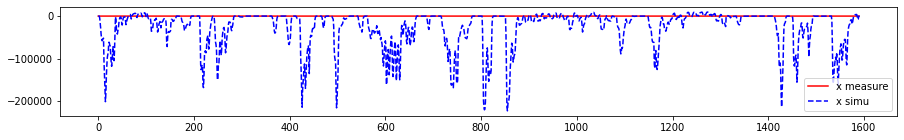

n train: 32 , R2: -42.88547103750862


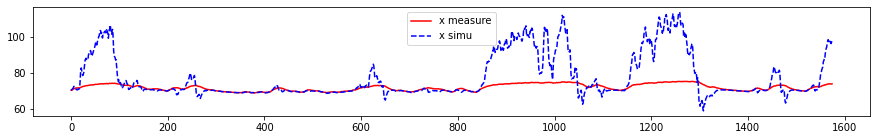

n train: 64 , R2: 0.9980262795717847


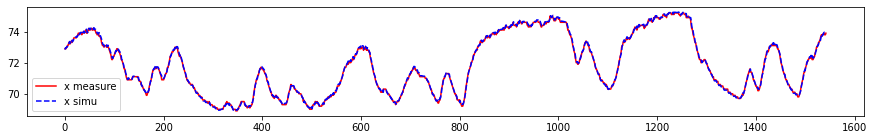

n train: 128 , R2: 0.9980735055891616


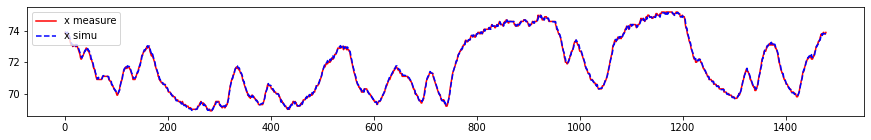

In [5]:
for n_train in [16, 32, 64, 128]:
    
    # DATA
    df = pd.read_csv('C:/Users/tln229/Downloads/Python/1. Building/data/HVAC_B90_102_exp_10m_20210424.csv')

    Tz  = np.array(df['room_temp']).reshape(-1,1)
    Tsa = np.array(df['supply_discharge_temp']).reshape(-1,1)
    msa = np.array(df['airflow_current']).reshape(-1,1)

    Tz_k   = Tz[0:n_train]
    y      = Tz[1:n_train+1]
    Tsa_k1 = Tsa[1:n_train+1]
    msa_k1 = msa[1:n_train+1]
    ones   = np.ones((n_train,1))

    x0     = np.copy(Tz_k)
    x1     = np.copy(Tsa_k1)
    x2     = np.copy(msa_k1)
    x02    = x0**2
    x12    = x1**2
    x22    = x2**2
    x0x1   = x0*x1
    x0x2   = x0*x2
    x1x2   = x1*x2
    x03    = x0**3
    x13    = x1**3
    x23    = x2**3
    x02x1  = x0*x0*x1
    x0x12  = x0*x1*x1
    x02x2  = x0*x0*x2
    x0x22  = x0*x2*x2
    x12x2  = x1*x1*x2
    x1x22  = x1*x2*x2
    x0x1x2 = x0*x1*x2

    x0_t = Tz[n_train:-1]
    y_t  = Tz[n_train+1:]
    x1_t = Tsa[n_train+1:]
    x2_t = msa[n_train+1:]
    ones_t = np.ones((Tz.shape[0]-n_train-1, 1))

    A = np.concatenate((ones, x0, x1, x2, x02, x12, x22, x0x1, x0x2, x1x2, x03, x13, x23, x02x1, x0x12, x02x2, x0x22, x12x2, x1x22, x0x1x2), axis=1)
    b = np.copy(y)

    # SINDy with STLS
    alpha = 0.002
    para = ()
    A1 = np.copy(A)
    while(1):
        c = np.linalg.lstsq(A1, b, rcond=-1)[0]
        c = c*(np.abs(c)>alpha)
        para = para + (c,)

        cols = np.array([], dtype=np.int32)
        for i in range(c.shape[0]):
            if c[i] == 0:
                cols = np.append(cols, i)
        if(cols.shape[0] == 0):
            break
        A1 = np.delete(A1, cols, axis=1)
    
    c = convert(para)
    x_simu = system(c, ones_t, x0_t, x1_t, x2_t)
    print('n train:', n_train, ", R2:", r2_score(y_t, x_simu))

    # plot
    plt.figure(figsize=(15, 2))
    plt.plot(y_t,      'r-',  label='x measure')
    plt.plot(x_simu, 'b--', label='x simu')
    plt.legend()
    plt.show()
